In [1]:
import pennylane as qml
from pennylane import numpy as np
from scipy.optimize import minimize

import numpy as np
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [2]:
# Exercise 1

# Define the quantum device and the number of qubits
dev = qml.device("default.qubit", wires=2)

# Quantum circuit architecture
def circuit(params, x):
    qml.RY(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(params[2], wires=0)
    qml.RY(params[3], wires=1)
    qml.CNOT(wires=[0, 1])

# Quantum node for the circuit
@qml.qnode(dev)
def quantum_node(params, x):
    circuit(params, x)
    return qml.expval(qml.PauliZ(0))

# Quantum kernel function
def quantum_kernel(x1, x2, params):
    return quantum_node(params, x1) * quantum_node(params, x2)

# QSVM
def qsvm(x, y, params, alpha, x_new):
    kernel_matrix = np.zeros((len(x), len(x)))
    for i, x1 in enumerate(x):
        for j, x2 in enumerate(x):
            kernel_matrix[i, j] = quantum_kernel(x1, x2, params)

    # Compute the predicted value for the new data point
    prediction = np.sum(alpha * y * kernel_matrix) + np.sum(params[4:] * x_new)

    return np.sign(prediction)

# Cost function to be minimized (QSVM objective function)
def cost(params, x, y, alpha):
    return -sum([alpha[i] * y[i] * sum([alpha[j] * y[j] * quantum_kernel(x[i], x[j], params) for j in range(len(x))]) for i in range(len(x))])

# Training the QSVM by minimizing the cost function
def train_qs(params, x, y, alpha):
    res = minimize(cost, params, args=(x, y, alpha), method='COBYLA')
    return res.x

# Generate some toy data for binary classification
x = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])
y = np.array([1, 1, -1, -1])

# Initialize the parameters randomly (adjust the number of parameters as per the circuit architecture)
params = np.random.rand(6)

# Initialize the QSVM parameters
alpha = np.random.rand(len(x))

# New data point to classify
x_new = np.array([0.5, 0.5])

# Train the QSVM
params_opt = train_qs(params, x, y, alpha)

# Test the QSVM on a new data point
prediction = qsvm(x, y, params_opt, alpha, x_new)
print("Prediction for new data point:", prediction)

Prediction for new data point: -1.0


PegasosQSVC classification test score: 1.0


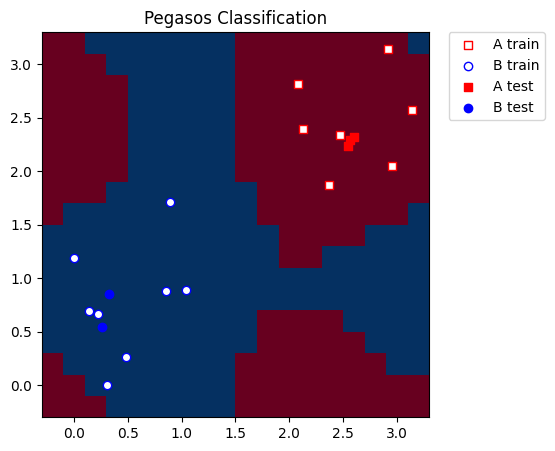

In [3]:
# Import necessary libraries
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from qiskit.circuit.library import ZFeatureMap
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import PegasosQSVC

# Generate a dataset
features, labels = make_blobs(n_samples=20, n_features=2, centers=2, random_state=3, shuffle=True)

# Preprocess features
features = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(features)

# Split dataset into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=15, shuffle=False
)

# Set QSVC parameters
num_qubits = 2
tau = 100
C = 1000

# Set random seed
algorithm_globals.random_seed = 12345

# Create feature map
feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=1)

# Define quantum kernel
qkernel = FidelityQuantumKernel(feature_map=feature_map)

# QSVC algorithm
pegasos_qsvc = PegasosQSVC(quantum_kernel=qkernel, C=C, num_steps=tau)

# Train QSVC model
pegasos_qsvc.fit(train_features, train_labels)

# Test QSVC model
pegasos_score = pegasos_qsvc.score(test_features, test_labels)
print(f"PegasosQSVC classification test score: {pegasos_score}")

#plot the results
grid_step = 0.2
margin = 0.2
grid_x, grid_y = np.meshgrid(
    np.arange(-margin, np.pi + margin, grid_step), np.arange(-margin, np.pi + margin, grid_step)
)

meshgrid_features = np.column_stack((grid_x.ravel(), grid_y.ravel()))
meshgrid_colors = pegasos_qsvc.predict(meshgrid_features)

plt.figure(figsize=(5, 5))
meshgrid_colors = meshgrid_colors.reshape(grid_x.shape)
plt.pcolormesh(grid_x, grid_y, meshgrid_colors, cmap="RdBu", shading="auto")

plt.scatter(
    train_features[:, 0][train_labels == 0],
    train_features[:, 1][train_labels == 0],
    marker="s",
    facecolors="w",
    edgecolors="r",
    label="A train",
)
plt.scatter(
    train_features[:, 0][train_labels == 1],
    train_features[:, 1][train_labels == 1],
    marker="o",
    facecolors="w",
    edgecolors="b",
    label="B train",
)

plt.scatter(
    test_features[:, 0][test_labels == 0],
    test_features[:, 1][test_labels == 0],
    marker="s",
    facecolors="r",
    edgecolors="r",
    label="A test",
)
plt.scatter(
    test_features[:, 0][test_labels == 1],
    test_features[:, 1][test_labels == 1],
    marker="o",
    facecolors="b",
    edgecolors="b",
    label="B test",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Pegasos Classification")
plt.show()